In [5]:
from collections import Counter
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.utils.data
import math
import torch.nn.functional as F

import pandas as pd

In [6]:
knowledgebase_url = 'https://github.com/AndiAlifs/FLUENT-Chatbot-2023/raw/main/KnowledgeBaseFilkom.xlsx'
knowledgebase = pd.read_excel(knowledgebase_url)

qa_paired = knowledgebase.drop(columns=knowledgebase.columns.drop(['Pertanyaan', 'Jawaban']))
qa_paired.dropna(inplace=True)
qa_paired

,Pertanyaan,Jawaban
0,email Fitra A. Bachtiar,fitra.bachtiar[at]ub.ac.id
1,NIK/NIP Fitra A. Bachtiar,198406282019031006
2,nama lengkap Fitra A. Bachtiar,Dr.Eng. Fitra A. Bachtiar
3,Departemen Fitra A. Bachtiar,Departemen Teknik Informatika
4,Program Studi Fitra A. Bachtiar,S2 Ilmu Komputer
...,...,...
1229,Apa Manfaat Konseling FILKOM ?,1. Masalah ditangani oleh ahli yang kompeten d...
1230,Berikan informasi mengenai Layanan Konseling,Informasi mengenai Layanan Konseling dapat dia...
1231,Siapa Konselor Bimbingan dan Konseling di FILK...,Ada 2 konselor Bimbingan dan Konseling di FILK...
1232,Siapa Koordinator Konselor Sebaya ?,Koordinator Konselor Sebaya adalah Muhammad Da...


In [7]:
def remove_punc(string):
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in string:
        if char not in punctuations:
            no_punct = no_punct + char  # space is also a character
    return no_punct.lower()

In [8]:
pairs = []
max_len = 90

for line in qa_paired.iterrows():
    pertanyaan = line[1]['Pertanyaan']
    jawaban = line[1]['Jawaban']
    qa_pairs = []
    first = remove_punc(pertanyaan.strip())      
    second = remove_punc(jawaban.strip())
    qa_pairs.append(first.split()[:max_len])
    qa_pairs.append(second.split()[:max_len])
    pairs.append(qa_pairs)

In [9]:
word_freq = Counter()
for pair in pairs:
    word_freq.update(pair[0])
    word_freq.update(pair[1])

In [10]:
min_word_freq = 2
words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 1
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 1
word_map['<pad>'] = 0

In [11]:
print("Total words are: {}".format(len(word_map)))

Total words are: 1079


In [12]:
with open('WORDMAP_corpus_KBFILKOM.json', 'w') as j:
    json.dump(word_map, j)

In [13]:
def encode_question(words, word_map):
    enc_c = [word_map.get(word, word_map['<unk>']) for word in words] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c

def encode_reply(words, word_map):
    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in words] + \
    [word_map['<end>']] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c

def encode_reply_with_maxlen(words, word_map):
    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in words] + [word_map['<end>']] + [word_map['<pad>']] * (max_len-2 - len(words))
    return enc_c

In [14]:
pairs_encoded = []
for pair in pairs:
    qus = encode_question(pair[0], word_map)
    ans = encode_reply(pair[1], word_map)
    pairs_encoded.append([qus, ans])

with open('pairs_encoded_kbfilkom.json', 'w') as p:
    json.dump(pairs_encoded, p)

In [15]:
pairs_encoded_same_length = []
for pair in pairs:
    qus = encode_question(pair[0], word_map)
    ans = encode_reply_with_maxlen(pair[1], word_map)
    pairs_encoded_same_length.append([qus, ans])

with open('pairs_encoded_kbfilkom_same_len.json', 'w') as p:
    json.dump(pairs_encoded_same_length, p)

In [16]:
rev_word_map = {v: k for k, v in word_map.items()}
' '.join([rev_word_map[v] for v in pairs_encoded[15][0]])

'tujuan filkom <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

In [17]:
class Dataset(Dataset):

    def __init__(self):

        self.pairs = json.load(open('pairs_encoded_kbfilkom.json'))
        self.dataset_size = len(self.pairs)

    def __getitem__(self, i):
        
        question = torch.LongTensor(self.pairs[i][0])
        reply = torch.LongTensor(self.pairs[i][1])
            
        return question, reply

    def __len__(self):
        return self.dataset_size

In [18]:
class Dataset_Same_Len(Dataset):

    def __init__(self):

        self.pairs = json.load(open('pairs_encoded_kbfilkom_same_len.json'))
        self.dataset_size = len(self.pairs)

    def __getitem__(self, i):
        
        question = torch.LongTensor(self.pairs[i][0])
        reply = torch.LongTensor(self.pairs[i][1])
            
        return question, reply

    def __len__(self):
        return self.dataset_size

In [19]:
train_loader = torch.utils.data.DataLoader(Dataset(),
                                           batch_size = 100, 
                                           shuffle=True, 
                                           pin_memory=True)

In [20]:
train_loader_same_len = torch.utils.data.DataLoader(Dataset_Same_Len(),
                                           batch_size = 50, 
                                           shuffle=True, 
                                           pin_memory=True)

In [21]:
def create_masks(question, reply_input, reply_target):
    
    def subsequent_mask(size):
        mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        return mask.unsqueeze(0)
    
    question_mask = question!=0
    question_mask = question_mask.to(device)
    question_mask = question_mask.unsqueeze(1).unsqueeze(1)         # (batch_size, 1, 1, max_words)
     
    reply_input_mask = reply_input!=0
    reply_input_mask = reply_input_mask.unsqueeze(1)  # (batch_size, 1, max_words)
    reply_input_mask = reply_input_mask & subsequent_mask(reply_input.size(-1)).type_as(reply_input_mask.data) 
    reply_input_mask = reply_input_mask.unsqueeze(1) # (batch_size, 1, max_words, max_words)
    reply_target_mask = reply_target!=0              # (batch_size, max_words)
    
    return question_mask, reply_input_mask, reply_target_mask

In [22]:
import os

def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Directory created at {path}")
    else:
        print(f"Directory already exists at {path}")

# Architecture

## Embeddings

In [23]:
class Embeddings(nn.Module):
    """
    Implements embeddings of the words and adds their positional encodings. 
    """
    def __init__(self, vocab_size, d_model, max_len = 50, num_layers = 6):
        super(Embeddings, self).__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(0.1)
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = self.create_positinal_encoding(max_len, self.d_model)     # (1, max_len, d_model)
        self.te = self.create_positinal_encoding(num_layers, self.d_model)  # (1, num_layers, d_model)
        self.dropout = nn.Dropout(0.1)
        
    def create_positinal_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model).to(device)
        for pos in range(max_len):   # for each position of the word
            for i in range(0, d_model, 2):   # for each dimension of the each position
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)   # include the batch size
        return pe
        
    def forward(self, embedding, layer_idx):
        if layer_idx == 0:
            embedding = self.embed(embedding) * math.sqrt(self.d_model)
        embedding += self.pe[:, :embedding.size(1)]   # pe will automatically be expanded with the same batch size as encoded_words
        # embedding: (batch_size, max_len, d_model), te: (batch_size, 1, d_model)
        embedding += self.te[:, layer_idx, :].unsqueeze(1).repeat(1, embedding.size(1), 1)
        embedding = self.dropout(embedding)
        return embedding

class EmbeddingsLSTM(nn.Module):
    """
    Implements embeddingsLSTM of the words and adds their positional encodings. 
    """
    def __init__(self, vocab_size, d_model, num_layers = 6):
        super(EmbeddingsLSTM, self).__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(0.1)
        self.embed = nn.Embedding(vocab_size, d_model)
        self.lstm = nn.LSTM(d_model, d_model, num_layers=num_layers)
        
    def forward(self, embedding, layer_idx, hidden, cell_state):
        if layer_idx == 0:
            embedding = self.embed(embedding) * math.sqrt(self.d_model)
        # Pass the embeddings through the LSTM\
        embedding, (hidden, cell_state) = self.lstm(embedding, (hidden, cell_state))
        print()
        print(embedding.size())
        print(embedding)
        return embedding, hidden, cell_state

class PretrainedEmbedding(nn.Module):
    """
    Implements embeddingsLSTM of the words and adds their positional encodings. 
    """
    def __init__(self, vocab_size, d_model, max_len = 50, num_layers = 6):
        super(PretrainedEmbedding, self).__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(0.1)
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = self.create_positinal_encoding(max_len, self.d_model)     # (1, max_len, d_model)
        self.te = self.create_positinal_encoding(num_layers, self.d_model)  # (1, num_layers, d_model)
        self.dropout = nn.Dropout(0.1)
        
    def create_positinal_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model).to(device)
        for pos in range(max_len):   # for each position of the word
            for i in range(0, d_model, 2):   # for each dimension of the each position
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)   # include the batch size
        return pe
        
    def forward(self, embedding, layer_idx):
        if layer_idx == 0:
            embedding = self.embed(embedding) * math.sqrt(self.d_model)
        embedding += self.pe[:, :embedding.size(1)]   # pe will automatically be expanded with the same batch size as encoded_words
        # embedding: (batch_size, max_len, d_model), te: (batch_size, 1, d_model)
        embedding += self.te[:, layer_idx, :].unsqueeze(1).repeat(1, embedding.size(1), 1)
        embedding = self.dropout(embedding)
        print()
        print(embedding.size())
        print(embedding)
        return embedding

## Multi-Head Attention

In [24]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, heads, d_model):
        super(MultiHeadAttention, self).__init__()
        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = nn.Dropout(0.1)
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.concat = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        """
        query, key, value of shape: (batch_size, max_len, 512)
        mask of shape: (batch_size, 1, 1, max_words)
        """
        # (batch_size, max_len, 512)
        query = self.query(query)
        key = self.key(key)        
        value = self.value(value)   
        
        # (batch_size, max_len, 512) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)   
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        
        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0,1,3,2)) / math.sqrt(query.size(-1))
        scores = scores.masked_fill(mask == 0, -1e9)    # (batch_size, h, max_len, max_len)
        weights = F.softmax(scores, dim = -1)           # (batch_size, h, max_len, max_len)
        weights = self.dropout(weights)
        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)
        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, h * d_k)
        context = context.permute(0,2,1,3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)
        # (batch_size, max_len, h * d_k)
        interacted = self.concat(context)
        return interacted 

## Feed Forward Neural Network

In [25]:
class FeedForward(nn.Module):
    def __init__(self, d_model, middle_dim = 2048):
        super(FeedForward, self).__init__()
        
        self.fc1 = nn.Linear(d_model, middle_dim)
        self.fc2 = nn.Linear(middle_dim, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out

class FeedForwardLSTM(nn.Module):
    def __init__(self, d_model, middle_dim = 2048):
        super(FeedForwardLSTM, self).__init__()
        
        self.fc1 = nn.Linear(d_model, middle_dim)
        self.lstm = nn.LSTM(middle_dim, middle_dim)
        self.fc2 = nn.Linear(middle_dim, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out, _ = self.lstm(out)
        out = self.fc2(self.dropout(out))
        return out

class FeedForwardLayerNoReg(nn.Module):
    def __init__(self, d_model, middle_dim = 2048):
        super(FeedForward, self).__init__()
        
        self.fc1 = nn.Linear(d_model, middle_dim)
        self.fc2 = nn.Linear(middle_dim, d_model)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.fc2(out)
        return out

## Encoder

In [26]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, embeddings, mask):
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        interacted = self.layernorm(interacted + embeddings)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

class EncoderLayerNoReg(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayerNoReg, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)

    def forward(self, embeddings, mask):
        interacted = self.self_multihead(embeddings, embeddings, embeddings, mask)
        interacted = self.layernorm(interacted + embeddings)
        feed_forward_out = self.feed_forward(interacted)
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded
        
        

## Decoder

In [27]:
class DecoderLayer(nn.Module):
    
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.src_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        
    def forward(self, embeddings, encoded, src_mask, target_mask):
        query = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, target_mask))
        query = self.layernorm(query + embeddings)
        interacted = self.dropout(self.src_multihead(query, encoded, encoded, src_mask))
        interacted = self.layernorm(interacted + query)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        decoded = self.layernorm(feed_forward_out + interacted)
        return decoded

class DecoderLayerNoReg(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayerNoReg, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.src_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        
    def forward(self, embeddings, encoded, src_mask, target_mask):
        query = self.self_multihead(embeddings, embeddings, embeddings, target_mask)
        query = self.layernorm(query + embeddings)
        interacted = self.src_multihead(query, encoded, encoded, src_mask)
        interacted = self.layernorm(interacted + query)
        feed_forward_out = self.feed_forward(interacted)
        decoded = self.layernorm(feed_forward_out + interacted)
        return decoded

## Transformer Architecture

In [28]:
class Transformer(nn.Module):
    
    def __init__(self, d_model, heads, num_layers, word_map, max_len = 50):
        super(Transformer, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        self.vocab_size = len(word_map)
        self.embed = Embeddings(self.vocab_size, d_model, num_layers = num_layers, max_len = max_len)
        self.encoder = EncoderLayer(d_model, heads) 
        self.decoder = DecoderLayer(d_model, heads)
        self.logit = nn.Linear(d_model, self.vocab_size)
        
    def encode(self, src_embeddings, src_mask):
        for i in range(self.num_layers):
            src_embeddings = self.embed(src_embeddings, i)
            src_embeddings = self.encoder(src_embeddings, src_mask)
        return src_embeddings
    
    def decode(self, tgt_embeddings, target_mask, src_embeddings, src_mask):
        for i in range(self.num_layers):
            tgt_embeddings = self.embed(tgt_embeddings, i)
            tgt_embeddings = self.decoder(tgt_embeddings, src_embeddings, src_mask, target_mask)
        return tgt_embeddings
        
    def forward(self, src_words, src_mask, target_words, target_mask):
        encoded = self.encode(src_words, src_mask)
        decoded = self.decode(target_words, target_mask, encoded, src_mask)
        out = F.log_softmax(self.logit(decoded), dim = 2)
        return out

class TransformerNoReg(nn.Module):
    
    def __init__(self, d_model, heads, num_layers, word_map, max_len = 50):
        super(TransformerNoReg, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        self.vocab_size = len(word_map)
        self.embed = Embeddings(self.vocab_size, d_model, num_layers = num_layers, max_len = max_len)
        self.encoder = EncoderLayerNoReg(d_model, heads) 
        self.decoder = DecoderLayerNoReg(d_model, heads)
        self.logit = nn.Linear(d_model, self.vocab_size)
        
    def encode(self, src_embeddings, src_mask):
        for i in range(self.num_layers):
            src_embeddings = self.embed(src_embeddings, i)
            src_embeddings = self.encoder(src_embeddings, src_mask)
        return src_embeddings
    
    def decode(self, tgt_embeddings, target_mask, src_embeddings, src_mask):
        for i in range(self.num_layers):
            tgt_embeddings = self.embed(tgt_embeddings, i)
            tgt_embeddings = self.decoder(tgt_embeddings, src_embeddings, src_mask, target_mask)
        return tgt_embeddings
        
    def forward(self, src_words, src_mask, target_words, target_mask):
        encoded = self.encode(src_words, src_mask)
        decoded = self.decode(target_words, target_mask, encoded, src_mask)
        out = F.log_softmax(self.logit(decoded), dim = 2)
        return out

class TransformerLSTM(nn.Module):
    
    def __init__(self, d_model, heads, num_layers, word_map, max_len = 50):
        super(TransformerLSTM, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        self.vocab_size = len(word_map)
        self.embed = EmbeddingsLSTM(self.vocab_size, d_model, num_layers = num_layers)
        self.encoder = EncoderLayer(d_model, heads) 
        self.decoder = DecoderLayer(d_model, heads)
        self.logit = nn.Linear(d_model, self.vocab_size)
        self.max_len = max_len
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def encode(self, src_embeddings, src_mask):
        encoder_hidden = torch.zeros([self.num_layers, self.max_len, self.d_model]).to(self.device) # 1 = number of LSTM layers
        cell_state = torch.zeros([self.num_layers, self.max_len, self.d_model]).to(self.device)
        for i in range(self.num_layers):
            src_embeddings, encoder_hidden, cell_state = self.embed(src_embeddings, i, encoder_hidden, cell_state)
            src_embeddings = self.encoder(src_embeddings, src_mask)
        return src_embeddings, encoder_hidden, cell_state
    
    def decode(self, tgt_embeddings, target_mask, src_embeddings, src_mask, encoder_hidden, cell_state):
        zeros = torch.zeros((self.num_layers, 1, self.d_model), device=encoder_hidden.device)
        encoder_hidden = torch.cat((encoder_hidden, zeros), dim=1)
        decoder_input = torch.Tensor([[0]]).long().to(self.device) # 0 = SOS_token
        decoder_hidden = encoder_hidden
        print(decoder_hidden.size())
        for i in range(self.num_layers):
            tgt_embeddings, decoder_hidden, cell_state = self.embed(tgt_embeddings, i, decoder_hidden, cell_state)
            tgt_embeddings = self.decoder(tgt_embeddings, src_embeddings, src_mask, target_mask)
        return tgt_embeddings
        
    def forward(self, src_words, src_mask, target_words, target_mask):
        encoded, encoder_hidden, cell_state = self.encode(src_words, src_mask)
        decoded = self.decode(target_words, target_mask, encoded, src_mask, encoder_hidden, cell_state)
        out = F.log_softmax(self.logit(decoded), dim = 2)
        return out

class TransformerPreTrainedEmbedding(nn.Module):
    def __init__(self, d_model, heads, num_layers, word_map, max_len = 50):
        super(TransformerPreTrainedEmbedding, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        self.vocab_size = len(word_map)
        self.embed = PretrainedEmbedding(self.vocab_size, d_model, num_layers = num_layers, max_len = max_len)
        self.encoder = EncoderLayer(d_model, heads) 
        self.decoder = DecoderLayer(d_model, heads)
        self.logit = nn.Linear(d_model, self.vocab_size)
        
    def encode(self, src_embeddings, src_mask):
        for i in range(self.num_layers):
            src_embeddings = self.embed(src_embeddings, i)
            src_embeddings = self.encoder(src_embeddings, src_mask)
        return src_embeddings
    
    def decode(self, tgt_embeddings, target_mask, src_embeddings, src_mask):
        for i in range(self.num_layers):
            tgt_embeddings = self.embed(tgt_embeddings, i)
            tgt_embeddings = self.decoder(tgt_embeddings, src_embeddings, src_mask, target_mask)
        return tgt_embeddings
        
    def forward(self, src_words, src_mask, target_words, target_mask):
        encoded = self.encode(src_words, src_mask)
        decoded = self.decode(target_words, target_mask, encoded, src_mask)
        out = F.log_softmax(self.logit(decoded), dim = 2)
        return out

class TransformerDecoderOnly(nn.Module):    
    def __init__(self, d_model, heads, num_layers, word_map, max_len = 50):
        super(TransformerDecoderOnly, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        self.vocab_size = len(word_map)
        self.embed = Embeddings(self.vocab_size, d_model, num_layers = num_layers, max_len = max_len)
        self.encoder = EncoderLayer(d_model, heads) 
        self.decoder = DecoderLayer(d_model, heads)
        self.logit = nn.Linear(d_model, self.vocab_size)
    
    def decode(self, tgt_embeddings, target_mask, src_embeddings, src_mask):
        for i in range(self.num_layers):
            tgt_embeddings = self.embed(tgt_embeddings, i)
            tgt_embeddings = self.decoder(tgt_embeddings, src_embeddings, src_mask, target_mask)
        return tgt_embeddings
        
    def forward(self, src_words, src_mask, target_words, target_mask):
        encoded = self.embed(src_words, 0)
        decoded = self.decode(target_words, target_mask, encoded, src_mask)
        out = F.log_softmax(self.logit(decoded), dim = 2)
        return out

In [29]:
class AdamWarmup:
    
    def __init__(self, model_size, warmup_steps, optimizer):
        
        self.model_size = model_size
        self.warmup_steps = warmup_steps
        self.optimizer = optimizer
        self.current_step = 0
        self.lr = 0
        
    def get_lr(self):
        return self.model_size ** (-0.5) * min(self.current_step ** (-0.5), self.current_step * self.warmup_steps ** (-1.5))
        
    def step(self):
        # Increment the number of steps each time we call the step function
        self.current_step += 1
        lr = self.get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        # update the learning rate
        self.lr = lr
        self.optimizer.step()       
        

In [30]:
class LossWithLS(nn.Module):

    def __init__(self, size, smooth):
        super(LossWithLS, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False, reduce=False)
        self.confidence = 1.0 - smooth
        self.smooth = smooth
        self.size = size
        
    def forward(self, prediction, target, mask):
        """
        prediction of shape: (batch_size, max_words, vocab_size)
        target and mask of shape: (batch_size, max_words)
        """
        prediction = prediction.view(-1, prediction.size(-1))   # (batch_size * max_words, vocab_size)
        target = target.contiguous().view(-1)   # (batch_size * max_words)
        mask = mask.float()
        mask = mask.view(-1)       # (batch_size * max_words)
        labels = prediction.data.clone()
        labels.fill_(self.smooth / (self.size - 1))
        labels.scatter_(1, target.data.unsqueeze(1), self.confidence)
        loss = self.criterion(prediction, labels)    # (batch_size * max_words, vocab_size)
        loss = (loss.sum(1) * mask).sum() / mask.sum()
        return loss
        

# Define Neptune Experiment

In [31]:
import neptune

project = "andialifs/fluent-tesis-24"
api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjZTY2YWQ3My04OTBkLTQ2OWUtYTc1Ni1jYjk0MGZhMWFiNGEifQ=="

# Function

## Train

In [32]:
def train(train_loader, transformer, criterion, epoch):
    transformer.train()
    sum_loss = 0
    count = 0

    for i, (question, reply) in enumerate(train_loader):
        
        samples = question.shape[0]

        # Move to device
        question = question.to(device)
        reply = reply.to(device)

        # Prepare Target Data
        reply_input = reply[:, :-1]
        reply_target = reply[:, 1:]

        # Create mask and add dimensions
        question_mask, reply_input_mask, reply_target_mask = create_masks(question, reply_input, reply_target)

        # Get the transformer outputs
        out = transformer(question, question_mask, reply_input, reply_input_mask)

        # Compute the loss
        loss = criterion(out, reply_target, reply_target_mask)
        
        # Backprop
        transformer_optimizer.optimizer.zero_grad()
        loss.backward()
        transformer_optimizer.step()
        
        sum_loss += loss.item() * samples
        count += samples
        
        if i % 100 == 0:
            print("Epoch [{}][{}/{}]\tLoss: {:.3f}".format(epoch, i, len(train_loader), sum_loss/count))
    
    return sum_loss/count

## Evaluate

In [33]:
def evaluate(transformer, question, question_mask, max_len, word_map):
    """
    Performs Greedy Decoding with a batch size of 1
    """
    rev_word_map = {v: k for k, v in word_map.items()}
    transformer.eval()
    start_token = word_map['<start>']
    encoded = transformer.encode(question, question_mask)
    words = torch.LongTensor([[start_token]]).to(device)
    
    for step in range(max_len - 1):
        size = words.shape[1]
        target_mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        target_mask = target_mask.to(device).unsqueeze(0).unsqueeze(0)
        decoded = transformer.decode(words, target_mask, encoded, question_mask)
        predictions = transformer.logit(decoded[:, -1])
        _, next_word = torch.max(predictions, dim = 1)
        next_word = next_word.item()
        if next_word == word_map['<end>']:
            break
        words = torch.cat([words, torch.LongTensor([[next_word]]).to(device)], dim = 1)   # (1,step+2)
        
    # Construct Sentence
    if words.dim() == 2:
        words = words.squeeze(0)
        words = words.tolist()
        
    sen_idx = [w for w in words if w not in {word_map['<start>']}]
    sentence = ' '.join([rev_word_map[sen_idx[k]] for k in range(len(sen_idx))])
    
    return sentence

# Experiment

In [32]:
d_model = [512, 1024, 2048, 4096]
heads = [8, 16, 32]
num_layers = [5, 10]
epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('WORDMAP_corpus_KBFILKOM.json', 'r') as j:
    word_map = json.load(j)

transformer_experiment = pd.DataFrame(columns = ['experiment_id', 'd_model', 'heads', 'num_layers', 'train_loss'])
loss_history = {}

experiment_id = -1

for d_m in d_model:
    for h in heads:
        for n_l in num_layers:
            experiment_id += 1
            print('\nRunning for experiment {} with d_model {}, heads{}, num_layers{}\n'.format(experiment_id, d_m, h, n_l))

            transformer_experiment.loc[experiment_id, 'experiment_id'] = 'experiment_{}'.format(str(experiment_id))
            transformer_experiment.loc[experiment_id, 'd_model'] = d_m
            transformer_experiment.loc[experiment_id, 'heads'] = h
            transformer_experiment.loc[experiment_id, 'num_layers'] = n_l

            transformer = Transformer(d_model = d_m, heads = h, num_layers = n_l, word_map = word_map, max_len=95)
            transformer = transformer.to(device)
            adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
            transformer_optimizer = AdamWarmup(model_size = d_m, warmup_steps = 4000, optimizer = adam_optimizer)
            criterion = LossWithLS(len(word_map), 0.2)

            loss_list_experiment = []
            for epoch in range(epochs):
                loss_train = train(train_loader, transformer, criterion, epoch)

                state = {'epoch': epoch, 'transformer': transformer, 'transformer_optimizer': transformer_optimizer}
                torch.save(state, 'checkpoint_experiment_' + str(epoch) + 'id_'+ str(experiment_id) +'.pth.tar')

                loss_list_experiment.append(loss_train)

            transformer_experiment.loc[experiment_id, 'train_loss'] = loss_train
            loss_history['experiment_{}'.format(str(experiment_id))] = loss_list_experiment
            



Running for experiment 0 with d_model 512, heads8, num_layers5



c:\Users\andya\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


KeyboardInterrupt: 

In [ ]:
import yaml

with open('loss_history_transformer_experiment_KBFILKOM.yaml', 'w') as file:
    documents = yaml.dump(loss_history, file)

In [ ]:
transformer_experiment.dropna(inplace=True)
transformer_experiment

,experiment_id,d_model,heads,num_layers,train_loss
0,experiment_0,512,8,5,0.839085
1,experiment_1,512,8,10,1.912982
2,experiment_2,512,16,5,0.825608
3,experiment_3,512,16,10,1.912182
4,experiment_4,512,32,5,0.830021
5,experiment_5,512,32,10,1.924448
6,experiment_6,1024,8,5,0.512975
7,experiment_7,1024,8,10,1.580548
8,experiment_8,1024,16,5,0.511592
9,experiment_9,1024,16,10,1.522959


In [ ]:
import yaml

with open('history_rnn_150524.yaml', 'r') as file:
    history_rnn = yaml.load(file, Loader=yaml.FullLoader)

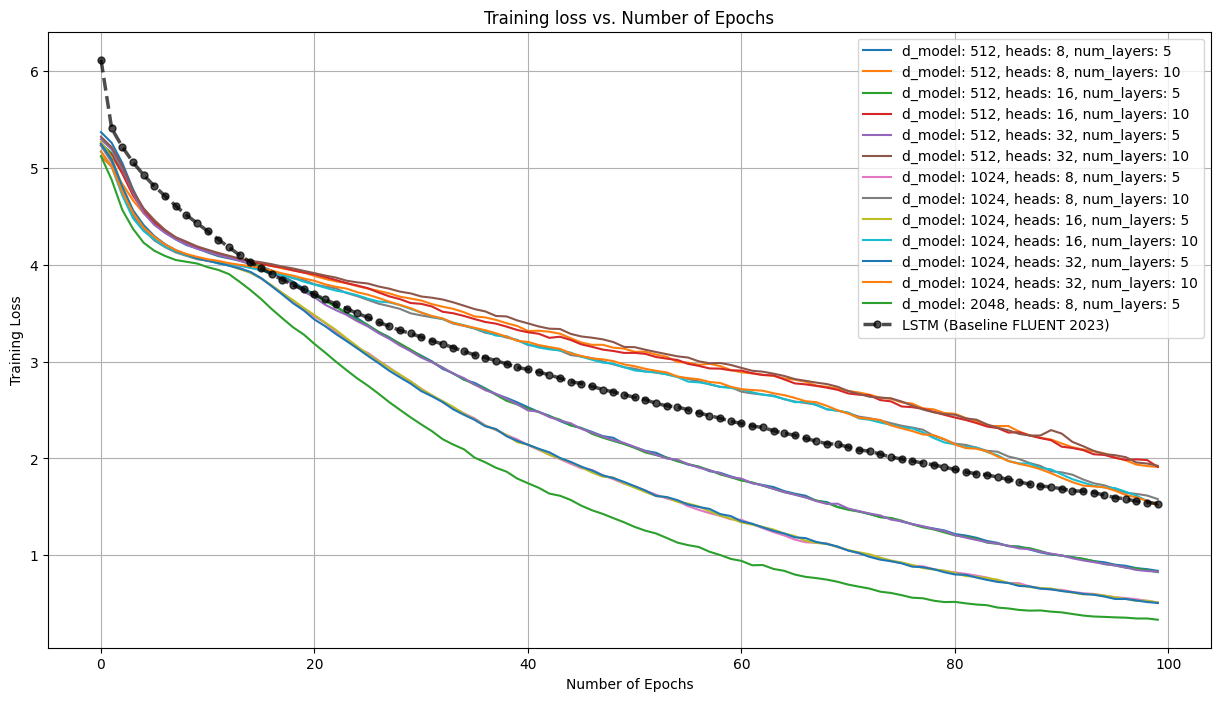

In [ ]:
import matplotlib 
import matplotlib.pyplot as plt

loss_history_key = list(loss_history.keys())

plt.figure(figsize=(15,8))
plt.title("Training loss vs. Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")


for key in loss_history_key:
    loss_list = loss_history[key]
    labels = f'd_model: {transformer_experiment[transformer_experiment["experiment_id"] == key]["d_model"].values[0]}, heads: {transformer_experiment[transformer_experiment["experiment_id"] == key]["heads"].values[0]}, num_layers: {transformer_experiment[transformer_experiment["experiment_id"] == key]["num_layers"].values[0]}'
    plt.plot(loss_list, label = labels)

    
plt.plot(history_rnn['loss'], 
                label = 'LSTM (Baseline FLUENT 2023)', 
                linestyle='dashed', 
                color='black', 
                linewidth=2.5, 
                alpha=0.7, 
                marker='o', 
                markerfacecolor='black', 
                markersize=5
        )

plt.legend()
plt.grid()

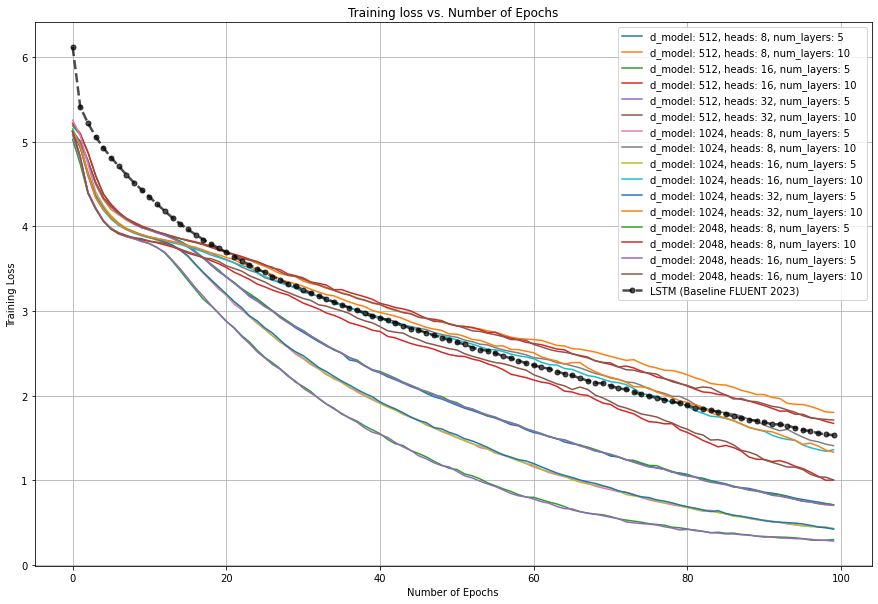

In [ ]:
import matplotlib 
import matplotlib.pyplot as plt

loss_history_key = list(loss_history.keys())

plt.figure(figsize=(15,10))
plt.title("Training loss vs. Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
z

for key in loss_history_key:
    loss_list = loss_history[key]
    labels = f'd_model: {transformer_experiment[transformer_experiment["experiment_id"] == key]["d_model"].values[0]}, heads: {transformer_experiment[transformer_experiment["experiment_id"] == key]["heads"].values[0]}, num_layers: {transformer_experiment[transformer_experiment["experiment_id"] == key]["num_layers"].values[0]}'
    plt.plot(loss_list, label = labels)

    
plt.plot(history_rnn['loss'], 
                label = 'LSTM (Baseline FLUENT 2023)', 
                linestyle='dashed', 
                color='black', 
                linewidth=2.5, 
                alpha=0.7, 
                marker='o', 
                markerfacecolor='black', 
                markersize=5
        )

plt.legend()
torch.cuda.is_available()plt.grid()

# Training

## Pretrained

In [77]:
directory = 'experiment_pretrained_1'

d_model = 2048
heads = 16
num_layers = 5
epochs = 100

loss_history_pratrained_embed_transformer = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('WORDMAP_corpus_KBFILKOM.json', 'r') as j:
    word_map = json.load(j)
    
transformer = TransformerPreTrainedEmbedding(d_model = d_model, heads = heads, num_layers = num_layers, word_map = word_map, max_len=95)
transformer = transformer.to(device)
adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
transformer_optimizer = AdamWarmup(model_size = d_model, warmup_steps = 4000, optimizer = adam_optimizer)
criterion = LossWithLS(len(word_map), 0.2)

for epoch in range(epochs):
    loss_train = train(train_loader, transformer, criterion, epoch)

    state = {'epoch': epoch, 'transformer': transformer, 'transformer_optimizer': transformer_optimizer}
    torch.save(state, directory + '/checkpoint_' + str(epoch) +'.pth.tar')

    loss_history_pratrained_embed_transformer.append(loss_train)

/home/andyalyfsyah/.conda/envs/myenv/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



torch.Size([100, 90, 2048])
tensor([[[  -4.5191,   50.5624,    0.0000,  ...,    5.9596,   -8.0914,
             7.4170],
         [  21.1835,  -32.8019,    2.5135,  ...,  -12.0732,    0.6595,
             0.0000],
         [   9.1062,   -6.3892,   69.0442,  ...,  -54.4731,  -90.4005,
            48.6294],
         ...,
         [ -68.7001,  -13.0567,   -3.5143,  ...,   79.5327,   67.9524,
           -78.4697],
         [ -67.7476,  -12.0546,   -3.9737,  ...,   79.5327,   67.9524,
           -78.4697],
         [ -66.8313,  -11.7860,   -3.4453,  ...,   79.5327,   67.9524,
           -78.4697]],

        [[ -60.7689,   -5.1273,   71.5492,  ...,   -9.0693, -115.8350,
           -40.0406],
         [ -36.5924,   81.6685,  -72.3661,  ...,  114.3140,  -25.8074,
             6.2455],
         [ -70.5471,   14.0965,  -23.4235,  ...,    7.0582,  -30.7245,
            79.4537],
         ...,
         [  -0.0000,  -13.0567,   -3.5143,  ...,   79.5327,   67.9524,
           -78.4697],
         [ 

KeyboardInterrupt: 

## Vanilla

In [33]:
directory = 'experiment_vanilla_30624'
create_directory(directory)

d_model = 2048
heads = 16
num_layers = 5
epochs = 100

loss_history_vanilla_transformer = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('WORDMAP_corpus_KBFILKOM.json', 'r') as j:
    word_map = json.load(j)
    
transformer = Transformer(d_model = d_model, heads = heads, num_layers = num_layers, word_map = word_map, max_len=95)
transformer = transformer.to(device)
adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
transformer_optimizer = AdamWarmup(model_size = d_model, warmup_steps = 4000, optimizer = adam_optimizer)
criterion = LossWithLS(len(word_map), 0.2)

for epoch in range(epochs):
    loss_train = train(train_loader, transformer, criterion, epoch)

    state = {'epoch': epoch, 'transformer': transformer, 'transformer_optimizer': transformer_optimizer}
    torch.save(state, directory + '/checkpoint_' + str(epoch) +'.pth.tar')

    loss_history_vanilla_transformer.append(loss_train)

import yaml 

with open(directory + '/loss_history_vanilla_transformer.yaml', 'w') as file:
    yaml.dump(loss_history_vanilla_transformer, file)

Directory already exists at experiment_vanilla_30624


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 79.35 GiB total capacity; 4.32 GiB already allocated; 4.19 MiB free; 4.42 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Vanilla without Regularization

In [34]:
directory = 'experiment_vanillanoreg_31624_cpu'
create_directory(directory)

run = neptune.init_run(
    project=project,
    api_token=api_token,
    name=directory,
)  

parameters = {
    'd_model': 2048,
    'heads': 16,
    'num_layers': 5,
    'epochs': 100,
}
run['parameters'] = parameters

loss_history_vanillanoreg_transformer = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
# device = "cpu"

with open('WORDMAP_corpus_KBFILKOM.json', 'r') as j:
    word_map = json.load(j)
    
transformer = TransformerNoReg(d_model = parameters['d_model'], heads = parameters['heads'], num_layers = parameters['num_layers'], word_map = word_map, max_len=95)
transformer = transformer.to(device)
adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
transformer_optimizer = AdamWarmup(model_size = parameters['d_model'], warmup_steps = 4000, optimizer = adam_optimizer)
criterion = LossWithLS(len(word_map), 0.2)

for epoch in range(parameters['epochs']):
    loss_train = train(train_loader, transformer, criterion, epoch)

    state = {'epoch': epoch, 'transformer': transformer, 'transformer_optimizer': transformer_optimizer}
    torch.save(state, directory + '/checkpoint_' + str(epoch) +'.pth.tar')
    run['model_checkpoint'].upload(directory + '/checkpoint_' + str(epoch) +'.pth.tar')

    loss_history_vanillanoreg_transformer.append(loss_train)
    run['train/loss'].append(loss_train)

with open(directory + '/loss_history_vanillanoreg_transformer.yaml', 'w') as file:
    yaml.dump(loss_history_vanilla_transformer, file)

run.stop()

Directory already exists at experiment_vanillanoreg_31624_cpu


[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/andialifs/fluent-tesis-24/e/FLUENT24-9


/home/andyalyfsyah/.conda/envs/myenv/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


OutOfMemoryError: CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 79.35 GiB total capacity; 4.26 GiB already allocated; 48.19 MiB free; 4.38 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Decoder Only

In [44]:
directory = 'experiment_deconly_17624'
create_directory(directory)

d_model = 2048
heads = 16
num_layers = 5
epochs = 100

loss_history_decoder_transformer = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('WORDMAP_corpus_KBFILKOM.json', 'r') as j:
    word_map = json.load(j)
    
transformer = TransformerDecoderOnly(d_model = d_model, heads = heads, num_layers = num_layers, word_map = word_map, max_len=95)
transformer = transformer.to(device)
adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
transformer_optimizer = AdamWarmup(model_size = d_model, warmup_steps = 4000, optimizer = adam_optimizer)
criterion = LossWithLS(len(word_map), 0.2)

for epoch in range(epochs):
    loss_train = train(train_loader, transformer, criterion, epoch)

    state = {'epoch': epoch, 'transformer': transformer, 'transformer_optimizer': transformer_optimizer}
    torch.save(state, directory + '/checkpoint_' + str(epoch) +'.pth.tar')

    loss_history_decoder_transformer.append(loss_train)

Directory already exists at experiment_deconly_17624
Epoch [0][0/12]	Loss: 5.239
Epoch [1][0/12]	Loss: 5.221
Epoch [2][0/12]	Loss: 5.199
Epoch [3][0/12]	Loss: 5.175
Epoch [4][0/12]	Loss: 5.128
Epoch [5][0/12]	Loss: 5.110
Epoch [6][0/12]	Loss: 5.041
Epoch [7][0/12]	Loss: 4.960
Epoch [8][0/12]	Loss: 4.799
Epoch [9][0/12]	Loss: 4.631
Epoch [10][0/12]	Loss: 4.653
Epoch [11][0/12]	Loss: 4.376
Epoch [12][0/12]	Loss: 4.351
Epoch [13][0/12]	Loss: 4.281
Epoch [14][0/12]	Loss: 3.955
Epoch [15][0/12]	Loss: 4.113
Epoch [16][0/12]	Loss: 3.999
Epoch [17][0/12]	Loss: 3.746
Epoch [18][0/12]	Loss: 3.667
Epoch [19][0/12]	Loss: 3.705
Epoch [20][0/12]	Loss: 3.673
Epoch [21][0/12]	Loss: 3.675
Epoch [22][0/12]	Loss: 3.572
Epoch [23][0/12]	Loss: 3.544
Epoch [24][0/12]	Loss: 3.512
Epoch [25][0/12]	Loss: 3.372
Epoch [26][0/12]	Loss: 3.404
Epoch [27][0/12]	Loss: 3.416
Epoch [28][0/12]	Loss: 3.384
Epoch [29][0/12]	Loss: 3.301
Epoch [30][0/12]	Loss: 3.204
Epoch [31][0/12]	Loss: 3.153
Epoch [32][0/12]	Loss: 3.029


## LSTM_Transformer

In [36]:
directory = 'experiment_2_lstm'

d_model = 1024
heads = 32
num_layers = 10
epochs = 100


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_history_lstm_transformer = []

with open('WORDMAP_corpus_KBFILKOM.json', 'r') as j:
    word_map = json.load(j)
    
transformer = TransformerLSTM(d_model = d_model, heads = heads, num_layers = num_layers, word_map = word_map, max_len=90)
transformer = transformer.to(device)
adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
transformer_optimizer = AdamWarmup(model_size = d_model, warmup_steps = 4000, optimizer = adam_optimizer)
criterion = LossWithLS(len(word_map), 0.2)


for epoch in range(epochs):
    loss_train = train(train_loader, transformer, criterion, epoch)

    state = {'epoch': epoch, 'transformer': transformer, 'transformer_optimizer': transformer_optimizer}
    torch.save(state, directory + '/checkpoint_' + str(epoch) +'.pth.tar')

    loss_history_lstm_transformer.append(loss_train)

/home/andyalyfsyah/.conda/envs/myenv/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



torch.Size([100, 90, 1024])
tensor([[[-1.3614e-03, -4.3624e-03, -1.0824e-02,  ...,  1.4897e-04,
          -8.0209e-03, -2.2607e-03],
         [-1.3613e-03, -4.3624e-03, -1.0824e-02,  ...,  1.4904e-04,
          -8.0207e-03, -2.2607e-03],
         [-1.3614e-03, -4.3625e-03, -1.0824e-02,  ...,  1.4906e-04,
          -8.0208e-03, -2.2607e-03],
         ...,
         [-1.3613e-03, -4.3625e-03, -1.0824e-02,  ...,  1.4902e-04,
          -8.0208e-03, -2.2607e-03],
         [-1.3613e-03, -4.3625e-03, -1.0824e-02,  ...,  1.4902e-04,
          -8.0208e-03, -2.2607e-03],
         [-1.3613e-03, -4.3625e-03, -1.0824e-02,  ...,  1.4902e-04,
          -8.0208e-03, -2.2607e-03]],

        [[-1.2595e-03, -7.5952e-03, -1.7628e-02,  ..., -1.2847e-03,
          -1.3483e-02, -3.4328e-03],
         [-1.2593e-03, -7.5956e-03, -1.7629e-02,  ..., -1.2847e-03,
          -1.3483e-02, -3.4326e-03],
         [-1.2597e-03, -7.5958e-03, -1.7628e-02,  ..., -1.2847e-03,
          -1.3482e-02, -3.4327e-03],
         .

RuntimeError: Expected hidden[1] size (10, 91, 1024), got [10, 90, 1024]

In [36]:
import yaml

with open(directory + '/loss_history_lstm_transformer.yaml', 'w') as file:
    yaml.dump(loss_history_lstm_transformer, file)

In [31]:
directory = 'experiment_1'
checkpoint = torch.load(directory + '/checkpoint_99.pth.tar')
transformer = checkpoint['transformer']

question = "Visi FILKOM" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

<unk>


In [ ]:
checkpoint

{'epoch': 99,
 'transformer': Transformer(
   (embed): Embeddings(
     (dropout): Dropout(p=0.1, inplace=False)
     (embed): Embedding(952, 2048)
   )
   (encoder): EncoderLayer(
     (layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
     (self_multihead): MultiHeadAttention(
       (dropout): Dropout(p=0.1, inplace=False)
       (query): Linear(in_features=2048, out_features=2048, bias=True)
       (key): Linear(in_features=2048, out_features=2048, bias=True)
       (value): Linear(in_features=2048, out_features=2048, bias=True)
       (concat): Linear(in_features=2048, out_features=2048, bias=True)
     )
     (feed_forward): FeedForward(
       (fc1): Linear(in_features=2048, out_features=2048, bias=True)
       (fc2): Linear(in_features=2048, out_features=2048, bias=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (dropout): Dropout(p=0.1, inplace=False)
   )
   (decoder): DecoderLayer(
     (layernorm): LayerNorm((2048,), eps=1e-05, elementwise

# Reset Cache

In [1]:
import torch

torch.cuda.empty_cache()

print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |